## Notebook to test gravity code only (no tidal interactions)

In [1]:
# Packages
import h5py
import time
import numpy as np
from amuse.lab import Particles
from amuse.couple import bridge
import matplotlib.pyplot as plt
from amuse.units.constants import G
from amuse.units import units, constants
from amuse.lab import Huayno, nbody_system
from amuse.community.ph4.interface import ph4
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

In [2]:
def system_with_moons(moons, eccentricities, inclinations, *args):
    
    ''' Function to create a particle system of the Galileann moon(s) with Jupiter and the Sun.
        
    @Input: 
        list of Galileann Moon names in string format (any combination of: io, europa, ganymede, callisto), 
        list of eccentricities, list of inclinations (dimensionless).
               
    @Returns: 
        Particle system of the given moon set with the Sun and Jupiter.
        
    @Example: 
        system = make_moon_system(moons=['io', 'europa'], eccentricities=[0.4, 0.6], inclinations=[50, 60]) ''';
    
    
    # Assigning our variables
    x = zip(eccentricities, inclinations)
    y = list(x)
    z = {}
    for i in range(len(moons)):
        z[moons[i]] = y[i]   
    
    
    # Initialising Sun and Jupiter
    Msun = 1.0|units.MSun
    Mjup = 1.0|units.MJupiter
    rSun = 696340|units.km
    rJup = 69911|units.km
    a_jup = 5.2|units.au
    e_jup = 0.0
    
    system = new_binary_from_orbital_elements(Msun, Mjup, a_jup, e_jup, G=constants.G)
    system[0].name = 'sun'
    system[1].name = 'jupiter'
    jupiter = system[system.name=='jupiter']
    jupiter.semimajor_axis = a_jup
    jupiter.radius = rJup
    sun = system[system.name=='sun']
    sun.radius = rSun
    
    
    # Function to automate addition of particles
    def add_particle(particle, a, e, inc, m, r):
        
        binary = new_binary_from_orbital_elements(jupiter.mass, m, a, eccentricity=e, inclination=inc, G=constants.G)
         
        system.add_particle(binary[1].as_set()) 
        system[-1].name = particle
        moon = system[system.name==particle] 
        
        moon.semimajor_axis = a
        moon.eccentricity = e
        moon.inclination = inc
        moon.radius = r
        moon.position = binary[1].position + jupiter.position
        moon.velocity = binary[1].velocity + jupiter.velocity
        
        system.move_to_center()
    
    
    # Add moons based on input
    if 'io' in moons:
        a = 421800|units.km
        e = z['io'][0]
        inc = z['io'][1]|units.deg
        m = 8.93E22|units.kg
        r = 1821.6|units.km
        add_particle('io', a, e, inc, m, r) 
    
    if 'europa' in moons:
        a = 671100|units.km
        e = z['europa'][0]
        inc = z['europa'][1]|units.deg
        m = 4.80E22|units.kg
        r = 1560.8|units.km
        add_particle('europa', a, e, inc, m, r)  

    if 'ganymede' in moons:
        a = 1070400|units.km
        e = z['ganymede'][0]
        inc = z['ganymede'][1]|units.deg
        m = 1.48E23|units.kg
        r = 2634.1|units.km
        add_particle('ganymede', a, e, inc, m, r)   
        
    if 'callisto' in moons:
        a = 1882700|units.km
        e = z['callisto'][0]
        inc = z['callisto'][1]|units.deg
        m = 1.08E23|units.kg
        r = 2410.3|units.km
        add_particle('callisto', a, e, inc, m, r)  
        
    print('Particle system created for: '+ str(system.name))
    return system

In [3]:
def integrate_system(moons, eccentricities, inclinations, dt, end_time):
    
    ''' Function to integrate the system over time using a gravity code.

    @Input: 
        list of Galileann Moon names in string format following the order of: io, europa,
        ganymede, callisto), eccentricities, inclinations, integration time step and end time.

    @Returns: 
        list of evolved eccentrities, inclinations, semimajor-axis values, and the time 
        range at time step intervals.

    @Example: 
        ecc, inc, sma, time_range = integrate_system(moons=['io'], eccentricities=[0.3], 
        inclinations=[50], 10|units.yr, 1000|units.yr) ''';
    
    
    # Checking how long code takes to run
    start_time = time.time()
    
    # Getting system
    system = system_with_moons(moons, eccentricities, inclinations)
    
    # Converting Nbody
    converter = nbody_system.nbody_to_si(system.mass.sum(), system[1].position.length())
    
    # Gravity code
    gravity = Huayno(converter)
    gravity.particles.add_particles(system)
    
    # Eccentricities
    e_io = []
    e_eu = []
    e_ga = []
    e_ca = []
    
    # Inclinations
    i_io = [] | units.deg
    i_eu = [] | units.deg
    i_ga = [] | units.deg
    i_ca = [] | units.deg
    
    #Semimajor axes 
    a_io = [] | units.m
    a_eu = [] | units.m
    a_ga = [] | units.m
    a_ca = [] | units.m
        
    # Channels
    channel = gravity.particles.new_channel_to(system)
    
    # Running gravity code
    dt = dt|units.yr
    end_time = end_time|units.yr
    time_range = np.arange(0, end_time.value_in(units.yr), dt.value_in(units.yr)) | units.yr
    
    for tstep in time_range:
        
        if 'io' in moons:
            orbit_io = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='io')],
                                                        G=constants.G)
            
        if 'europa' in moons:
            orbit_eu = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='europa')],
                                                        G=constants.G)
            
        if 'ganymede' in moons:
            orbit_ga = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='ganymede')],
                                                        G=constants.G)
            
        if 'callisto' in moons:
            orbit_ca = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='callisto')],
                                                        G=constants.G)
        
        
        gravity.evolve_model(tstep)
        channel.copy()
        
        if 'io' in moons:
            a_io.append(orbit_io[2])
            e_io.append(orbit_io[3])
            i_io.append(orbit_io[5])
            
        
        if 'europa' in moons:
            a_eu.append(orbit_eu[2])
            e_eu.append(orbit_eu[3])
            i_eu.append(orbit_eu[5])
            
        
        if 'ganymede' in moons:
            a_ga.append(orbit_ga[2])
            e_ga.append(orbit_ga[3])
            i_ga.append(orbit_ga[5])
            
        
        if 'callisto' in moons:
            a_ca.append(orbit_ca[2])
            e_ca.append(orbit_ca[3])
            i_ca.append(orbit_ca[5])
        
        
    gravity.stop()
    
    
    ecc = []
    inc = [] | units.deg
    sma = [] | units.m
    
    if 'io' in moons:
        ecc.append(e_io)
        inc.append(i_io)
        sma.append(a_io)
        
    if 'europa' in moons:
        ecc.append(e_eu)
        inc.append(i_eu)
        sma.append(a_eu)
        
    if 'ganymede' in moons:
        ecc.append(e_ga)
        inc.append(i_ga)
        sma.append(a_ga)
        
    if 'callisto' in moons:
        ecc.append(e_ca)
        inc.append(i_ca)
        sma.append(a_ca)
        
    
    # Printing runtime
    print('Runtime: %s seconds' % (time.time() - start_time))
    
    
    return ecc, inc, sma, time_range

In [20]:
def check_lz(moons, ecc, inc, time_range, savefig=False, figname='kozai_constant'):
    
    ''' The Kozai-constant Lz should be (approximately) conserved for one moon.
    
        Lz = sqrt(1 - e**2) * cos(i) '''
    
    t = time_range.value_in(units.yr)
    e = ecc[0]
    i = inc[0].value_in(units.rad)
    
    # Equation
    lz = np.sqrt(1 - np.array(e)**2) * np.cos(i)
    
    # Standard deviations
    sdev = np.std(lz)
    
    # Plotting
    plt.rcParams.update({'font.size': 25})
    
    fig, ax = plt.subplots(figsize=[14,7], tight_layout=True)    
    
    ax.set_title('Kozai-constant: {}'.format(moons[0]), pad=10)
    ax.plot(t, lz, '-o', c='tab:blue', lw=2)
    ax.plot([], [], ' ', label='std = '+str(round(sdev,5)))
    ax.set_ylabel(r'L$_{z}$', labelpad=10)
    ax.set_xlabel('time [yr]')
    ax.tick_params(direction='in', length=6, width=2, top=True, right=True)
    ax.legend(frameon=False) 
    ax.set_xlim([0,1000])
    
    if savefig:
        plt.savefig(figname+'.png', facecolor='w', bbox_inches='tight')
    
    plt.show()

In [35]:
def plot_tracks(moons, ecc, inc, sma, time_range, a=True, savefig=False, figname='gravity_only'):
    
    plt.rcParams.update({'font.size': 25})
    
    if a:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[20, 15], tight_layout=True, sharex=True)
    else: 
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[25, 12], tight_layout=True, sharex=True)
        
    lines = ['-', '--', '-.', ':']
    cb = ['tab:purple', 'deepskyblue', 'tab:red', 'k']
    
    m = ['Io', 'Europa', 'Ganymede', 'Callisto']
    
    t = time_range.value_in(units.yr)
    inc = inc.value_in(units.deg)
    ecc = np.array(ecc)
    sma = sma.value_in(units.m)
    
    for i in range(len(moons)):
        ax1.plot(t, np.array(ecc[i]), c=cb[i], label=m[i], lw=3, ls=lines[i]) 
        ax2.plot(t, inc[i], c=cb[i], label=m[i], lw=3, ls=lines[i]) 
     
    ax1.set_title('Lidov-Kozai effects only', pad=10)
    ax1.set_ylabel('eccentricity', labelpad=10)
    ax2.set_ylabel('inclination [deg]')
    ax2.set_xlabel('time [yrs]')
    
    ax1.tick_params(direction='in', length=6, width=2, top=True, right=True)
    ax2.tick_params(direction='in', length=6, width=2, top=True, right=True)
    
    ax1.set_xlim([0,1000])
    ax2.set_xlim([0,1000])
    #ax1.set_ylim([0,0.9])
    #ax2.set_ylim([20,100])
    
    ax1.legend()
    ax2.legend(loc=2)
    
    if a:
        for i in range(len(moons)):
            ax3.plot(t, sma[i], c=cb[i], label=moons[i], lw=3, ls=lines[i])   
        ax3.set_ylabel('Semimajor Axis')
        ax3.set_xlabel('Time [yrs]')
        ax3.tick_params(direction='in', length=6, width=2, top=True, right=True)
        ax3.legend()    
    
    if savefig:
        plt.savefig(figname+'.png', facecolor='w', bbox_inches='tight')
    plt.show()

In [16]:
def lidov_kozai_demonstration(moons, ecc, inc, time_range, savefig=False):
    
    plt.rcParams.update({'font.size': 25})
    fig, ax = plt.subplots(1, figsize=(14, 7), tight_layout=True)
    name = moons[0]
    
    t = time_range.value_in(units.yr)
    inc = inc[0].value_in(units.deg)
    ecc = np.array(ecc[0])
    
    ax.set_title('LK cycles: {}'.format(name), pad=10)
    ax.plot(t, ecc, lw=2, c='tab:blue')
    ax.scatter(t, ecc, c='tab:blue')
    ax.set_xlabel('time [yr]')
    
    ax1 = ax.twinx()
    ax1.plot(t, inc, lw=2, ls='--', c='tab:red')
    ax1.scatter(t, inc, c='tab:red', marker='^')
    
    ax.tick_params(direction='in', length=6, width=2, top=True)
    ax.tick_params(axis='y', colors='tab:blue')
    ax.set_ylabel('eccentricity', labelpad=20, rotation=90, 
                  horizontalalignment='center', verticalalignment='center')

    ax1.tick_params(direction='in', length=6, width=2)
    ax1.tick_params(axis='y', colors='tab:red')
    ax1.set_ylabel('inclination [deg]', labelpad=20, rotation=90, 
                   horizontalalignment='center', verticalalignment='center')
    
    ax.set_xlim([0,1000])
    ax1.set_xlim([0,1000])
    
    if savefig:
        plt.savefig('gravity_only.png', facecolor='w', bbox_inches='tight', dpi=300)
        
    plt.show()

In [7]:
moons = ['europa']
inclinations = [70]
eccentricities = [0.4]

dt = 10
tend = 1001

ecc, inc, sma, time_range = integrate_system(moons, eccentricities, inclinations, dt, tend)

Particle system created for: ['sun' 'jupiter' 'europa']
Runtime: 18.45897603034973 seconds


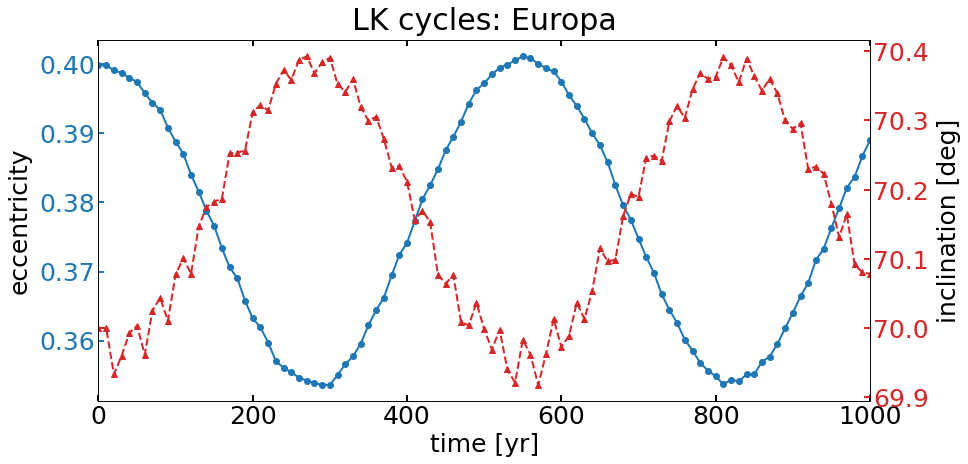

In [17]:
lidov_kozai_demonstration(moons, ecc, inc, time_range, savefig=True)

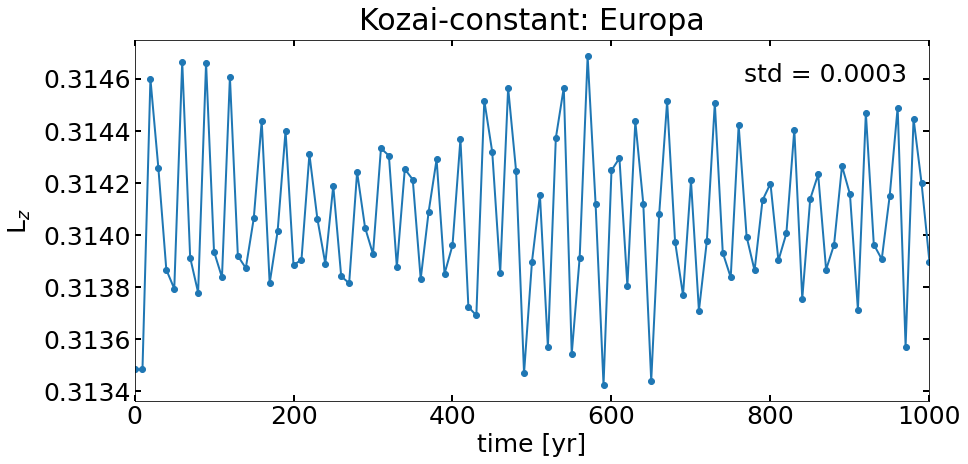

In [21]:
check_lz(moons, ecc, inc, time_range, savefig=False)

In [28]:
moons = ['io', 'europa', 'ganymede', 'callisto']
inclinations = [80, 70, 60, 50]
eccentricities = [0.2, 0.3, 0.4, 0.5]

inclinations = [80, 70, 60, 50]
eccentricities = [0.2, 0.2, 0.2, 0.2]

dt = 1
t_end = 1001
kdt = 360

ecc, inc, sma, time_range = integrate_system(moons, eccentricities, inclinations, dt, t_end)

Particle system created for: ['sun' 'jupiter' 'io' 'europa' 'ganymede' 'callisto']
Runtime: 81.33923435211182 seconds


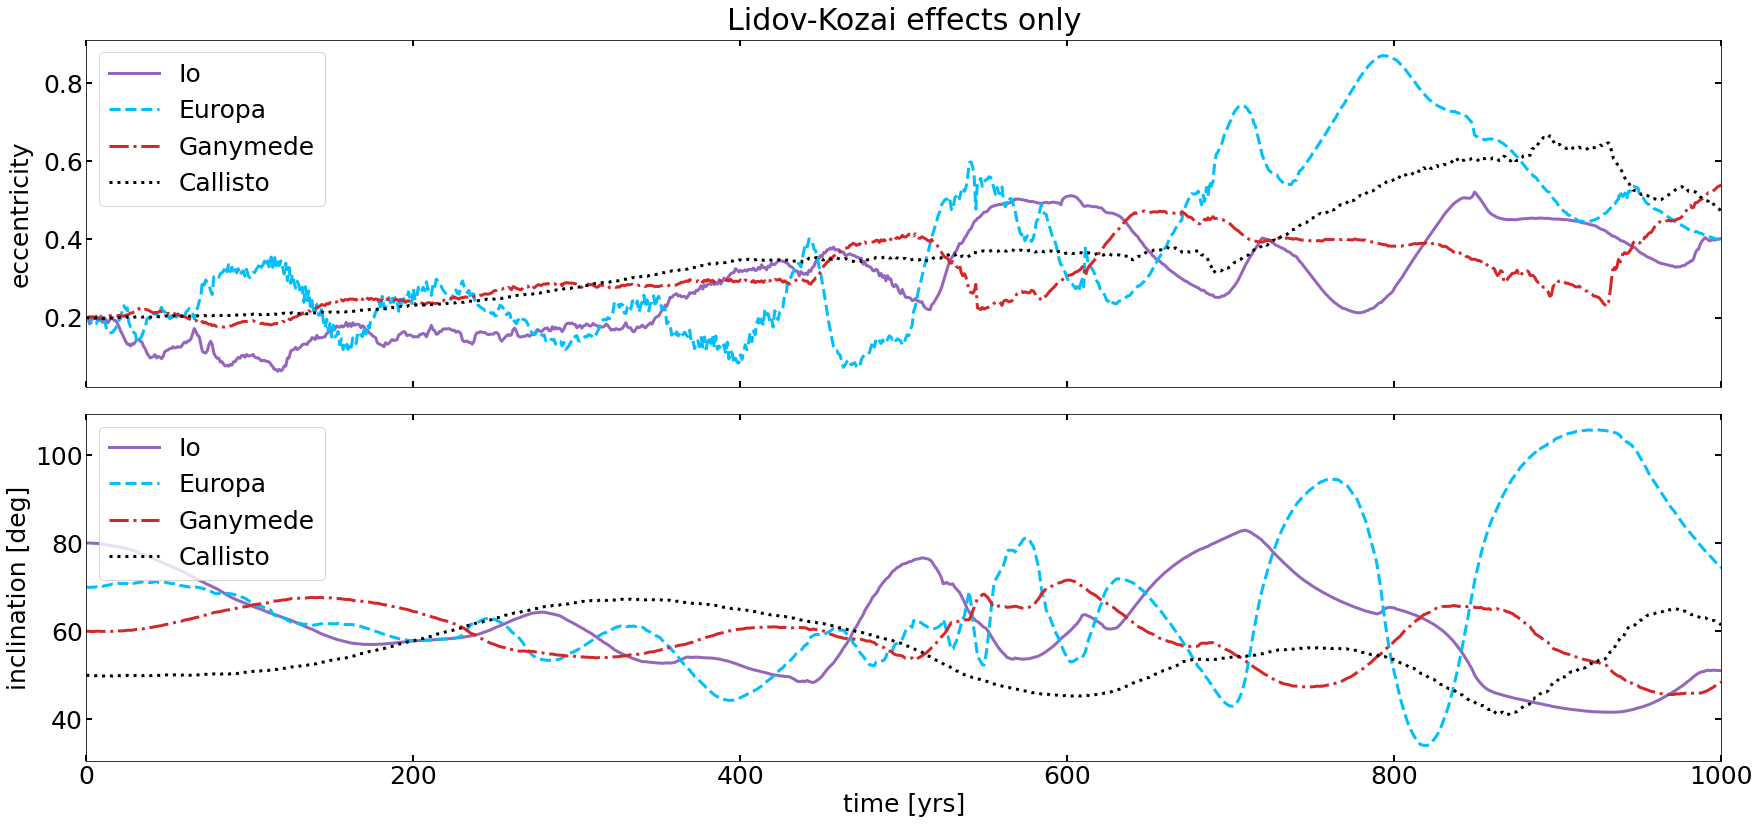

In [36]:
plot_tracks(moons, ecc, inc, sma, time_range, a=False, savefig=True)